In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob
import re

import sys
sys.path.append("./src/") 

import mnist_data
import plot_utils
import gzip

### Read time series data

In [2]:
def readData(filelists):

    try:
        savedir = './data'

        mergeddata = []
        for file in filelists:
            filename = file
            stocksavedir = savedir+'/'+filename

            np_data = []
            for _inputname in ['np_train','np_test']:
                with gzip.open( stocksavedir+'/'+_inputname+'.npy.gz', 'r') as infile:
                    np_data.append(np.load(infile))

            df_data = []
            for _inputname in ['df_train','df_test']:
                df_data.append(pd.read_pickle(stocksavedir+'/'+_inputname+'.pkl'))
            
            mergeddata.append([np_data[0],np_data[1],df_data[0],df_data[1]])

        return mergeddata

    except Exception as e:
        print(e)



In [3]:
filelists = ['DJI']
mergeddata = readData(filelists)
np_train = mergeddata[0][0]
print(np_train.shape)
np_test = mergeddata[0][1]
print(np_test.shape)
df_train = mergeddata[0][2]
# print(df_train.head())
print(df_train.shape)
# df_train['signal_5ma'][:10]
df_train['id'] = 0
df_train.loc[(df_train['signal_5ma'] == 9) , ['id']] = 1
df_train.loc[(df_train['signal_5ma'] == 8) , ['id']] = 2
df_train.loc[(df_train['signal_5ma'] == -9) , ['id']] = 3
df_train.loc[(df_train['signal_5ma'] == 0) , ['id']] = 0


(2079, 4323)
(891, 4323)
(2079, 30)


### build variational autoencoder

In [4]:
class vae:
    def __init__(self,session,learning_rate,dense_layers,dense_funcs,dim_z,dim_out):

        self.session = session
        self.dim_in = dim_out
        self.dim_out = dim_out
        self.dim_z = dim_z
        
        self.lrate = learning_rate
        self.dense_layers = dense_layers
        self.dense_funcs = dense_funcs
        
        self.model_name = 'vae'
        self.logs_dir = './model'
        self._build_network()
        
    def _build_network(self):
        
        self.x_hat = tf.placeholder(tf.float32, shape=[None, self.dim_in], name='input_denoising')
        self.x = tf.placeholder(tf.float32, shape=[None, self.dim_out], name='target')

        # dropout
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        # input for PMLR
        self.z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')
        
        self.encoder_dense_layers = self.dense_layers+[self.dim_z]
        self.encoder_dense_funcs = self.dense_funcs
        print("encoder_dense_layers {}".format(self.encoder_dense_layers))
        
        self.mu,self.sigma = self.encoder(self.x_hat,self.encoder_dense_layers,self.encoder_dense_funcs,self.keep_prob)
        
        print("mu:{} sigma:{}".format(self.mu.shape,self.sigma.shape))
        # sampling by re-parameterization technique
        self.z = self.mu + self.sigma * tf.random_normal(tf.shape(self.mu), 0, 1, dtype=tf.float32)
        print("encoder output z:{}".format(self.z.shape))

        self.decoder_dense_layers = self.dense_layers[::-1]+[self.dim_out]
        self.decoder_activ = self.encoder_dense_funcs[::-1]
        print("decoder_dense_layers {}".format(self.decoder_dense_layers))
        
        # decoding
        self.y = self.decoder(self.z, self.decoder_dense_layers,self.decoder_activ, self.keep_prob)
        self.y = tf.clip_by_value(self.y, 1e-8, 1 - 1e-8)
        print("decoder output y:{}".format(self.y.shape))
        # loss
        self.marginal_likelihood = tf.reduce_sum(self.x * tf.log(self.y) + (1 - self.x) * tf.log(1 - self.y), 1)
        self.KL_divergence = 0.5 * tf.reduce_sum(tf.square(self.mu) + tf.square(self.sigma) - tf.log(1e-8 + tf.square(self.sigma)) - 1, 1)

        self.marginal_likelihood = tf.reduce_mean(self.marginal_likelihood)
        self.KL_divergence = tf.reduce_mean(self.KL_divergence)

        self.ELBO = self.marginal_likelihood - self.KL_divergence

        self.loss = -self.ELBO
        
        self.decoded = self.sample_decoder(self.z_in, self.dim_out)
        
        self.train_op = tf.train.AdamOptimizer(self.lrate).minimize(self.loss)
        self.neg_marginal_likelihood = -1*self.marginal_likelihood
        
        self.global_step = tf.Variable(0, name='global_step',trainable=False)
        self.saver = tf.train.Saver(max_to_keep=1)
        
        
    def save(self, step):
        model_name = self.model_name + ".model"
                
        model_logs_dir = self.logs_dir
        if not os.path.exists(model_logs_dir):
            os.makedirs(model_logs_dir)
            
        self.saver.save(
            self.session,
            os.path.join(model_logs_dir, model_name),
            global_step=step
        )
    def load(self):
    
        ckpt = tf.train.get_checkpoint_state(self.logs_dir)
        
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            # print('ckpt_name {} self.logs_dir {}'.format(ckpt_name,self.logs_dir))
            self.saver.restore(self.session, os.path.join(self.logs_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter

        else:
            print(" [*] Failed to find a " +self.logs_dir+ " checkpoint")
            return False, 0
    
    def sample_decoder(self,z, dim_img):

        # decoding
        y = self.decoder(z, self.decoder_dense_layers,self.decoder_activ, 1.0, reuse=True)
        return y
    
    def encoder(self,x, dense_layers,dense_func,keep_prob):
        with tf.variable_scope("encoder"):

            # initializers
            w_init = tf.contrib.layers.variance_scaling_initializer()
            b_init = tf.constant_initializer(0.)

            # dense layers
            dense_input_shape = x.get_shape()[1]
            dense_input = x
            for _i,_n_hidden in enumerate(dense_layers[:-1]):
                net_w = tf.get_variable('w'+str(_i),[dense_input_shape,_n_hidden],initializer=w_init)
                net_b = tf.get_variable('b'+str(_i),[_n_hidden],initializer = b_init)
                net_h = tf.matmul(dense_input,net_w) + net_b 
                if dense_func[_i] == 'elu':
                    actfunc = tf.nn.elu
                elif dense_func[_i] == 'tanh':
                    actfunc = tf.nn.tanh
                net_h = actfunc(net_h)
                net_h = tf.nn.dropout(net_h,keep_prob)
                dense_input_shape = net_h.get_shape()[1]
                dense_input = net_h

            # final output
            final_w = tf.get_variable("w_final",[dense_input.get_shape()[1],dense_layers[-1]*2],initializer = w_init)
            final_b = tf.get_variable("b_final",[dense_layers[-1]*2],initializer=b_init)
            gaussian_params = tf.matmul(dense_input,final_w) + final_b

            mean = gaussian_params[:,:dense_layers[-1]]
            stddev = 1e-6 +tf.nn.softplus(gaussian_params[:,dense_layers[-1]:])
            print("gaussian encoder mean:{} ".format(mean.shape))


        return mean, stddev
    
    # Bernoulli as decoder
    # bernoulli_decoder(z, [500,500,784],['tanh','elu'], keep_prob, reuse=False)
    def decoder(self,z, dense_layers,dense_func, keep_prob, reuse=False):

        with tf.variable_scope("decoder", reuse=reuse):
            # initializers
            w_init = tf.contrib.layers.variance_scaling_initializer()
            b_init = tf.constant_initializer(0.)

            # dense layers
            dense_input_shape = z.get_shape()[1]
            dense_input = z
            for _i,_n_hidden in enumerate(dense_layers[:-1]):
                net_w = tf.get_variable('w'+str(_i),[dense_input_shape,_n_hidden],initializer=w_init)
                net_b = tf.get_variable('b'+str(_i),[_n_hidden],initializer = b_init)
                net_h = tf.matmul(dense_input,net_w) + net_b 
                if dense_func[_i] == 'elu':
                    actfunc = tf.nn.elu
                elif dense_func[_i] == 'tanh':
                    actfunc = tf.nn.tanh
                net_h = actfunc(net_h)
                net_h = tf.nn.dropout(net_h,keep_prob)
                dense_input_shape = net_h.get_shape()[1]
                dense_input = net_h

            # final output
            final_w = tf.get_variable("w_final",[dense_input.get_shape()[1],dense_layers[-1]],initializer = w_init)
            final_b = tf.get_variable("b_final",[dense_layers[-1]],initializer=b_init)
            y = tf.sigmoid(tf.matmul(dense_input,final_w)+final_b)


        return y


In [6]:

with tf.Session() as sess:
        
    learning_rate= 0.0005
    dense_layers = [1500,700,300]
    dense_funcs = ['elu','elu','tanh']
    dim_z = 2#20 # latent vector size
    dim_out = np_train.shape[1]
    
    
    autoencoder = vae(sess,learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
    sess.run(tf.global_variables_initializer(), feed_dict={autoencoder.keep_prob : 0.9})
    
    # train
    n_epochs = 200
    batch_size = 40
    n_samples = np_train.shape[0]
    total_batch = int(n_samples / batch_size)
    ADD_NOISE = True
    train_total_data = np_train
    
    for epoch in range(n_epochs):

        # Random shuffling
        np.random.shuffle(train_total_data)
        train_data_ = train_total_data

        # Loop over all batches
        for i in range(total_batch):
            # Compute the offset of the current minibatch in the data.
            offset = (i * batch_size) % (n_samples)
            batch_xs_input = train_data_[offset:(offset + batch_size), :]

            batch_xs_target = batch_xs_input
            
            
            # add salt & pepper noise
            if ADD_NOISE:
                batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
                batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)
            
            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (autoencoder.train_op, autoencoder.loss, autoencoder.neg_marginal_likelihood, autoencoder.KL_divergence),
                feed_dict={autoencoder.x_hat: batch_xs_input, autoencoder.x: batch_xs_target, autoencoder.keep_prob : 0.9})
            
            
#         print("epoch {}".format(epoch))
        # print cost every epoch
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))

        
    autoencoder.save(1)

encoder_dense_layers [1500, 700, 300, 2]
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [300, 700, 1500, 4323]
decoder output y:(?, 4323)
epoch 0: L_tot 2867.42 L_likelihood 2857.96 L_divergence 9.45
epoch 1: L_tot 2870.09 L_likelihood 2864.08 L_divergence 6.01
epoch 2: L_tot 2855.02 L_likelihood 2849.36 L_divergence 5.67
epoch 3: L_tot 2848.71 L_likelihood 2844.13 L_divergence 4.58
epoch 4: L_tot 2828.04 L_likelihood 2824.32 L_divergence 3.72
epoch 5: L_tot 2815.72 L_likelihood 2811.70 L_divergence 4.03
epoch 6: L_tot 2772.65 L_likelihood 2768.78 L_divergence 3.87
epoch 7: L_tot 2799.08 L_likelihood 2795.67 L_divergence 3.40
epoch 8: L_tot 2814.77 L_likelihood 2811.07 L_divergence 3.70
epoch 9: L_tot 2811.79 L_likelihood 2808.42 L_divergence 3.37
epoch 10: L_tot 2818.30 L_likelihood 2814.59 L_divergence 3.71
epoch 11: L_tot 2803.16 L_likelihood 2799.91 L_divergence 3.25
epoch 12: L_tot 2822.19 L_likelihood 2818.75 L_divergence 3.44
ep

epoch 127: L_tot 2790.15 L_likelihood 2786.56 L_divergence 3.59
epoch 128: L_tot 2814.83 L_likelihood 2811.42 L_divergence 3.41
epoch 129: L_tot 2780.55 L_likelihood 2777.44 L_divergence 3.10
epoch 130: L_tot 2782.25 L_likelihood 2779.16 L_divergence 3.09
epoch 131: L_tot 2803.35 L_likelihood 2800.13 L_divergence 3.22
epoch 132: L_tot 2783.79 L_likelihood 2780.66 L_divergence 3.13
epoch 133: L_tot 2763.56 L_likelihood 2760.27 L_divergence 3.29
epoch 134: L_tot 2794.17 L_likelihood 2791.10 L_divergence 3.06
epoch 135: L_tot 2789.85 L_likelihood 2786.44 L_divergence 3.42
epoch 136: L_tot 2762.79 L_likelihood 2759.49 L_divergence 3.30
epoch 137: L_tot 2811.12 L_likelihood 2807.56 L_divergence 3.56
epoch 138: L_tot 2782.74 L_likelihood 2779.78 L_divergence 2.96
epoch 139: L_tot 2777.58 L_likelihood 2774.61 L_divergence 2.97
epoch 140: L_tot 2795.38 L_likelihood 2791.78 L_divergence 3.60
epoch 141: L_tot 2760.21 L_likelihood 2757.12 L_divergence 3.09
epoch 142: L_tot 2780.80 L_likelihood 27

In [5]:
import matplotlib.pyplot as plt
def save_scattered_image(z, id, name='scattered_image.jpg'):
    N = 2
    z_range = 3
    plt.figure(figsize=(8, 6))
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(id, 1), marker='o', edgecolor='none', cmap=discrete_cmap(N, 'jet'))
    plt.colorbar(ticks=range(N))
    axes = plt.gca()
    axes.set_xlim([-z_range-2, z_range+2])
    axes.set_ylim([-z_range-2, z_range+2])
    plt.grid(True)
    plt.savefig("./results/time/" + name)


def discrete_cmap(N, base_cmap=None):

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


encoder_dense_layers [1500, 700, 300, 2]
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [300, 700, 1500, 4323]
decoder output y:(?, 4323)
INFO:tensorflow:Restoring parameters from ./model/vae.model-1
 [*] Success to read vae.model-1


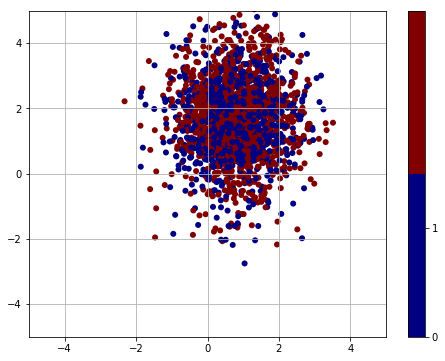

In [6]:

with tf.Session() as sess:
    learning_rate= 0.0005
    dense_layers = [1500,700,300]
    dense_funcs = ['elu','elu','tanh']
    dim_z = 2#20 # latent vector size
    dim_out = np_train.shape[1]
    
    
    autoencoder = vae(sess,learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
    autoencoder.load()
    
    sess.run(tf.global_variables_initializer(), feed_dict={autoencoder.keep_prob : 0.9})
    
    PMLR = True
    ADD_NOISE = True
    if PMLR and dim_z == 2:
        
        # Plot for manifold learning result
#         PMLR = plot_utils.Plot_Manifold_Learning_Result('./results/time', PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

        x_PMLR = np_train
        id_PMLR = df_train['id'].values
        nb_classes = 4
        targets = id_PMLR
        one_hot_targets = np.eye(nb_classes)[targets]
#         x_PMLR = np_new
        
        if ADD_NOISE:
            x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
            x_PMLR += np.random.randint(2, size=x_PMLR.shape)

        z_PMLR = sess.run(autoencoder.z, feed_dict={autoencoder.x_hat: x_PMLR, autoencoder.keep_prob : 1})
        save_scattered_image(z_PMLR,one_hot_targets, name="/PMLR_map_stock.jpg")
        

In [7]:
df_train = df_train.reset_index()
df_train.head()
id1 = df_train[df_train['id']==1].index
id1 = id1.values
id3 = df_train[df_train['id']==3].index
id3 = id3.values
# np_id1 = np_train[id1]
# np_id1

In [8]:
# id1 = id1.values
# type(id1)
np_new = np.concatenate((np_train[id1],np_train[id3]),axis=0)
np_new.shape

(65, 4323)

In [9]:

id1_list = np.zeros(len(id1)).astype(int)
id3_list = np.ones(len(id3)).astype(int)
id_list = np.concatenate((id1_list,id3_list),axis=0)
id_list
nb_classes = 2
targets = id_list
one_hot_targets = np.eye(nb_classes)[targets]
# one_hot_targets

In [ ]:
id_PMLR = df_train['id'].values
nb_classes = 2
targets = id_PMLR
one_hot_targets = np.eye(nb_classes)[targets]


In [ ]:

N = 4
z_range = 3
plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(id, 1), marker='o', edgecolor='none', cmap=discrete_cmap(N, 'jet'))
plt.colorbar(ticks=range(N))
axes = plt.gca()
axes.set_xlim([-z_range-2, z_range+2])
axes.set_ylim([-z_range-2, z_range+2])
plt.grid(True)